In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
%pylab inline
import requests, re
import pandas as pd
import seaborn as sns
import nltk

import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#  Part-1

# conditions to filter data between 10 and 90 perentile quantile :


# Setting thresholds based on analysis
min_length_threshold = df1['review_length'].quantile(0.1)  # 10th percentile
max_length_threshold = df1['review_length'].quantile(0.9)  # 90th percentile
min_word_count_threshold = df1['word_count'].quantile(0.1)  # 10th percentile
max_word_count_threshold = df1['word_count'].quantile(0.9)  # 90th percentile

# Count the number of reviews per business and set thresholds
business_review_counts = df1['business_id'].value_counts()
min_reviews_per_business_threshold = business_review_counts.quantile(0.1)  # 10th percentile
max_reviews_per_business_threshold = business_review_counts.quantile(0.9)  # 90th percentile

# Identify businesses that meet the review count thresholds
filtered_business_ids = business_review_counts[(business_review_counts >= min_reviews_per_business_threshold) &
                                               (business_review_counts <= max_reviews_per_business_threshold)].index

# Filtering the data
filtered_df = df1[(df1['review_length'] >= min_length_threshold) & 
                  (df1['review_length'] <= max_length_threshold) &
                  (df1['word_count'] >= min_word_count_threshold) &
                  (df1['word_count'] <= max_word_count_threshold) &
                  (df1['business_id'].isin(filtered_business_ids))]

print("\nAfter applying thresholds:")
print(filtered_df.info())


In [3]:
df2= pd.read_csv('16_Nov_cleaned_eng_preprocessed_imp.csv')
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365837 entries, 0 to 365836
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   review_id             365837 non-null  object 
 1   user_id               365837 non-null  object 
 2   business_id           365837 non-null  object 
 3   stars                 365837 non-null  float64
 4   useful                365837 non-null  int64  
 5   funny                 365837 non-null  int64  
 6   cool                  365837 non-null  int64  
 7   text                  365837 non-null  object 
 8   date                  365835 non-null  object 
 9   text_no_stop          365835 non-null  object 
 10  review_length         365837 non-null  int64  
 11  word_count            365837 non-null  int64  
 12  reviews_per_business  365837 non-null  int64  
 13  is_english            365837 non-null  bool   
 14  processed_text        365837 non-null  object 
dtype

In [4]:
# Define the valid star values
valid_stars = [1, 2, 3, 4, 5]

# Filter the DataFrame
df2 = df2[df2['stars'].isin(valid_stars)]



# Convert float64 columns to int64
int_columns = ['useful', 'funny', 'review_length', 'word_count', 'reviews_per_business']
for col in int_columns:
    df2[col] = df2[col].fillna(0).astype('int64')

# Convert 'cool' from object to int64
# Ensure that 'cool' contains only numeric values or NaN
df2['cool'] = pd.to_numeric(df2['cool'], errors='coerce').fillna(0).astype('int64')

# Convert 'date' from object to datetime64[ns]
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')

# Convert 'is_english' from object to bool
# Assuming 'is_english' contains values that can be interpreted as boolean
df2['is_english'] = df2['is_english'].astype('bool')

# Check the updated DataFrame info
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365837 entries, 0 to 365836
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   review_id             365837 non-null  object        
 1   user_id               365837 non-null  object        
 2   business_id           365837 non-null  object        
 3   stars                 365837 non-null  float64       
 4   useful                365837 non-null  int64         
 5   funny                 365837 non-null  int64         
 6   cool                  365837 non-null  int64         
 7   text                  365837 non-null  object        
 8   date                  365835 non-null  datetime64[ns]
 9   text_no_stop          365835 non-null  object        
 10  review_length         365837 non-null  int64         
 11  word_count            365837 non-null  int64         
 12  reviews_per_business  365837 non-null  int64         
 13 

# doing stratified sampling extracting 3,000 rows which 

In [5]:
import pandas as pd
import numpy as np

# Assuming df2 is your DataFrame

# Define the stratification strategy
def stratified_sample(df, col, n_samples):
    n = min(n_samples, df[col].nunique())
    return df.groupby(col, group_keys=False).apply(lambda x: x.sample(int(np.rint(n_samples * len(x) / len(df))))).sample(frac=1).reset_index(drop=True)

# Multi-feature stratification
sample_size = 2700  # Adjusted for the final total of 3000
stratified_samples = []
for col in ['stars', 'business_id']:  # Add other columns as necessary
    stratified_samples.append(stratified_sample(df2, col, sample_size // 2))

# Combine stratified samples
combined_stratified_sample = pd.concat(stratified_samples).drop_duplicates().reset_index(drop=True)

# Random sampling for the remaining
remaining_size = 3000 - combined_stratified_sample.shape[0]
random_sample = df2.sample(n=remaining_size)

# Final sample
final_sample = pd.concat([combined_stratified_sample, random_sample]).sample(frac=1).reset_index(drop=True)

# Check the final sample info
print(final_sample.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   review_id             3000 non-null   object        
 1   user_id               3000 non-null   object        
 2   business_id           3000 non-null   object        
 3   stars                 3000 non-null   float64       
 4   useful                3000 non-null   int64         
 5   funny                 3000 non-null   int64         
 6   cool                  3000 non-null   int64         
 7   text                  3000 non-null   object        
 8   date                  3000 non-null   datetime64[ns]
 9   text_no_stop          3000 non-null   object        
 10  review_length         3000 non-null   int64         
 11  word_count            3000 non-null   int64         
 12  reviews_per_business  3000 non-null   int64         
 13  is_english        

In [10]:
final_sample.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_no_stop,review_length,word_count,reviews_per_business,is_english,processed_text
0,ItpYr0ZMToDzfPQgyKWurg,D7VXsGrtaN9JKVWSrCuDOA,jFzEKWbzU6Ni465Wt1gR1Q,5.0,0,0,0,the service was quick fast thanks to a preorde...,2017-07-28 23:51:28,service quick fast thanks preorder phone didnt...,179,37,3,True,service quick fast thank preorder phone nt wai...
1,4Yns_xf7wwCLWfyqYV-1tw,kp6KaMGmKMSSOz5A-nYUgw,EBpicl13JZwCypP0NlbINA,2.0,0,1,0,first of all the service is terrible absolutel...,2016-11-06 19:58:27,first service terrible absolutely terrible cam...,862,161,13,True,service terrible absolutely terrible come half...
2,MVvq8RuV4cXjDDEsRqz96Q,gYDFiPYFCeY52vvMvvy5Pw,C5lUI7qJ8NnmawAFVPZg8A,2.0,2,1,1,while i love the free delivery and the fact th...,2012-01-30 20:41:07,love free delivery fact general tso tofu im ye...,665,126,24,True,love free delivery fact general tso tofu m con...
3,e0ZKSDoIib4_jk2Gx9G6Ug,6JejVLZl5M-IB3UkNTkXtQ,PRrWtQ3rdINngwESZNefVQ,4.0,0,0,0,a restaurant worth going out of your way for\n...,2018-11-26 21:21:25,restaurant worth going way guatamalan fare usi...,866,137,21,True,restaurant worth go way guatamalan fare fresh ...
4,TA3VLtCwA2ME_sss6Un74A,vPtJr5eioXEPqXq4-f7goA,JGVcrMpcaK6Wk0SEJLMx7w,5.0,0,0,0,i am usually in fit flavors 23 times a week w...,2017-11-02 22:47:13,usually fit flavors 23 times week wonderful he...,243,46,11,True,usually fit flavor time week wonderful healthy...


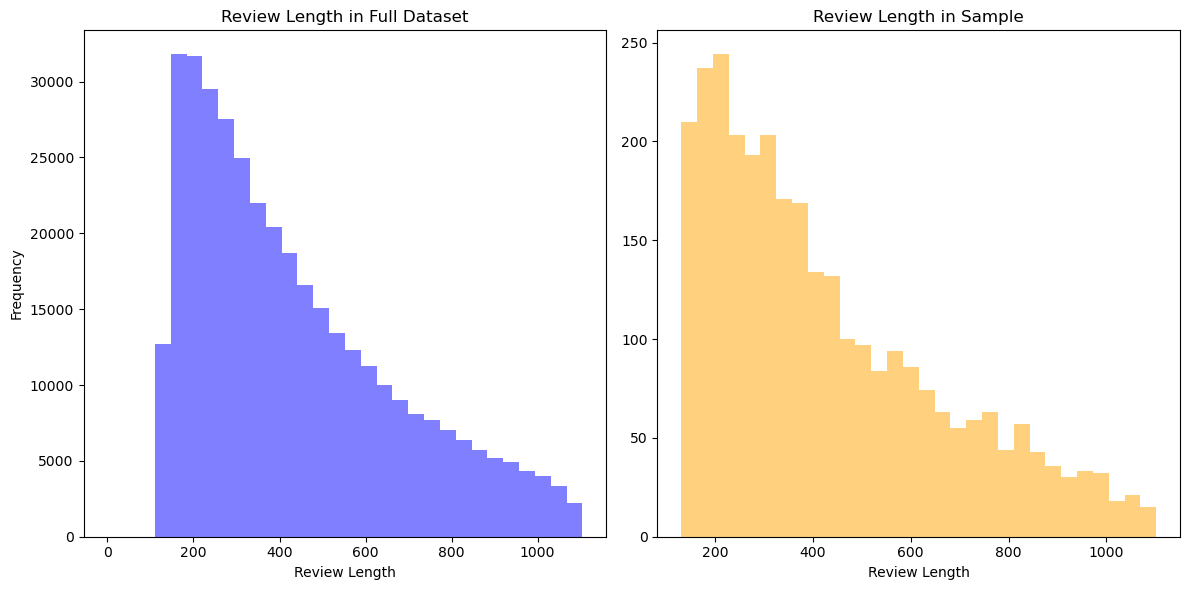

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df2['review_length'], bins=30, color='blue', alpha=0.5)
plt.title('Review Length in Full Dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(final_sample['review_length'], bins=30, color='orange', alpha=0.5)
plt.title('Review Length in Sample')
plt.xlabel('Review Length')

plt.tight_layout()
plt.show()

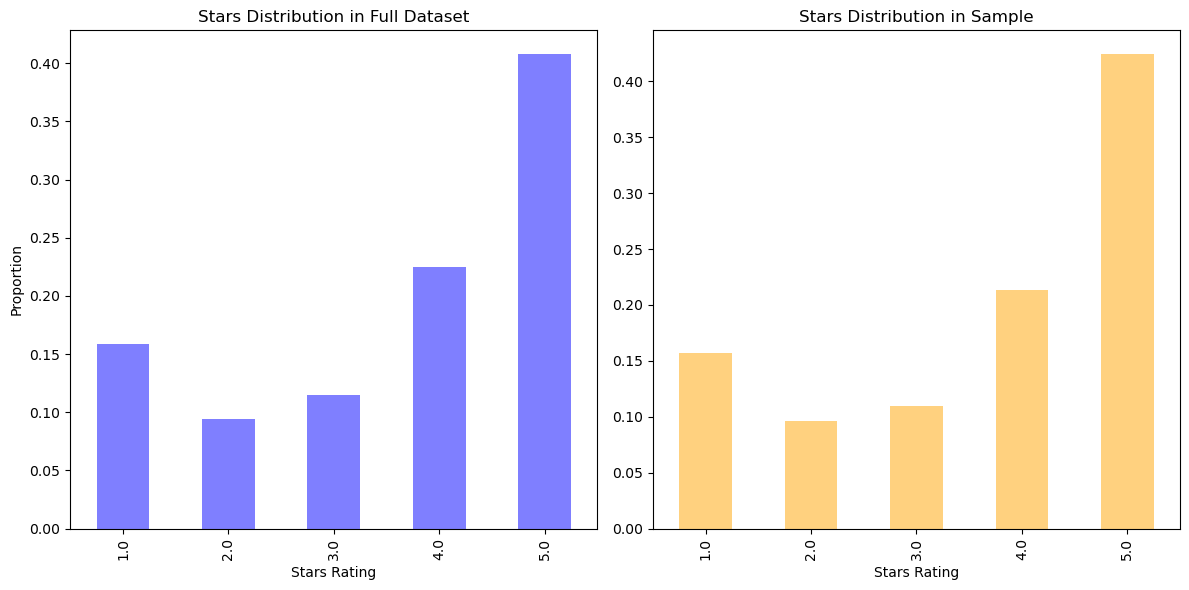

In [7]:
import matplotlib.pyplot as plt

# Assuming df2 is your full dataset and final_sample is your sampled data

# Distribution of 'stars' in the full dataset
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df2['stars'].value_counts(normalize=True).sort_index().plot(kind='bar', color='blue', alpha=0.5)
plt.title('Stars Distribution in Full Dataset')
plt.xlabel('Stars Rating')
plt.ylabel('Proportion')

# Distribution of 'stars' in the sample
plt.subplot(1, 2, 2)
final_sample['stars'].value_counts(normalize=True).sort_index().plot(kind='bar', color='orange', alpha=0.5)
plt.title('Stars Distribution in Sample')
plt.xlabel('Stars Rating')

plt.tight_layout()
plt.show()


In [8]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Add new stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Convert to list
data = final_sample['processed_text'].values.tolist()

# Tokenize and remove stop words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

# Create Dictionary and Corpus needed for Topic Modeling
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]


[nltk_data] Downloading package stopwords to /Users/ankur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from gensim.models import LdaMulticore

# Number of topics
num_topics = 10

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# View the topics in LDA model
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.018*"order" + 0.018*"food" + 0.017*"time" + 0.017*"nt" + 0.013*"great" + '
  '0.012*"good" + 0.009*"place" + 0.009*"like" + 0.007*"get" + 0.007*"eat"'),
 (1,
  '0.019*"place" + 0.018*"good" + 0.015*"nt" + 0.012*"food" + 0.010*"great" + '
  '0.009*"love" + 0.009*"get" + 0.009*"pizza" + 0.008*"restaurant" + '
  '0.008*"like"'),
 (2,
  '0.024*"good" + 0.023*"order" + 0.015*"food" + 0.012*"nt" + 0.012*"place" + '
  '0.008*"time" + 0.008*"get" + 0.008*"service" + 0.007*"eat" + 0.007*"come"'),
 (3,
  '0.021*"food" + 0.015*"place" + 0.014*"nt" + 0.013*"good" + 0.010*"great" + '
  '0.009*"service" + 0.008*"go" + 0.007*"sandwich" + 0.007*"chicken" + '
  '0.007*"look"'),
 (4,
  '0.019*"good" + 0.018*"food" + 0.017*"place" + 0.012*"nt" + 0.009*"time" + '
  '0.009*"service" + 0.008*"great" + 0.008*"go" + 0.007*"like" + 0.006*"love"'),
 (5,
  '0.021*"place" + 0.018*"good" + 0.018*"food" + 0.011*"nt" + 0.011*"great" + '
  '0.008*"service" + 0.007*"come" + 0.007*"order" + 0.007*"like" + '
 

Ordering and Timeliness (Topic 0): This topic, with keywords like "order," "time," and "food," suggests discussions about the ordering process and the timeliness of service. It might include aspects related to the speed and accuracy of order fulfillment.

Quality and Variety (Topic 3): With words like "food," "sandwich," "chicken," and "service," this topic seems to focus on the quality and variety of food items offered, as well as the service quality in the restaurant.

Atmosphere and Experience (Topic 1): Key terms like "place," "love," "restaurant," and "pizza" indicate a focus on the overall dining atmosphere and experience. It could encompass aspects such as the ambiance of the restaurant and the enjoyment of specific dishes like pizza.

Customer Satisfaction (Topic 9): Dominated by words like "food," "good," "restaurant," and "service," this topic is likely about overall customer satisfaction, covering both the quality of food and the level of service received.

Service Quality (Topic 6): Highlighted by words like "service," "staff," and "order," this topic appears to address the quality of service, including interactions with staff and experiences related to ordering.

Topic 0: General experience (mentions of "place", "good", "food", "service").

Topic 1: Quality of food and service ("good", "food", "service", "friendly").

Topic 2: Overall dining experience ("food", "place", "good", "great").

Topic 3: Enjoyment and specific dishes ("great", "love", "pizza").

Topic 4: Restaurant ambiance and food quality ("food", "restaurant", "chicken").

Topic 5: Casual dining experience ("good", "pizza", "go").

Topic 6: Service and dining experience ("service", "order", "go").

Topic 7: Specific dishes and service ("roll", "order", "service").

Topic 8: Ordering process and food quality ("order", "food", "chicken").

Topic 9: General satisfaction and service ("like", "come", "service").

In [36]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)


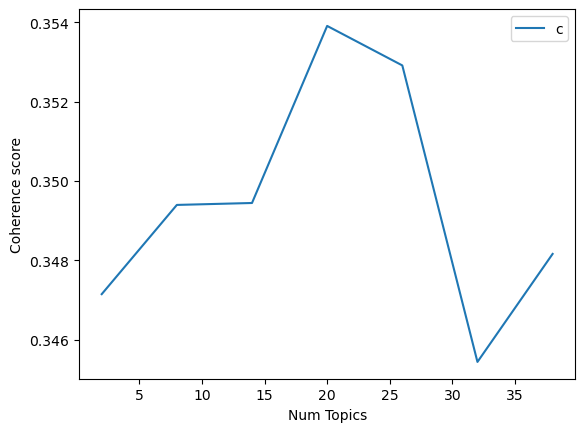

In [37]:
import matplotlib.pyplot as plt

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


Top 10 nouns for 1 star reviews:
food: 41921
place: 24686
time: 24437
order: 21620
service: 19871
minute: 14540
restaurant: 11643
customer: 10944
pizza: 10904
chicken: 8957

Top 10 nouns for 2 star reviews:
food: 27345
place: 16058
time: 14373
service: 12273
order: 8344
restaurant: 7147
chicken: 6987
pizza: 6450
minute: 5522
table: 5277

Top 10 nouns for 3 star reviews:
food: 31519
place: 21897
time: 15495
service: 14748
restaurant: 8461
chicken: 8419
pizza: 7641
price: 6827
menu: 6683
order: 6532

Top 10 nouns for 4 star reviews:
food: 53636
place: 44680
time: 27046
service: 25294
chicken: 15916
restaurant: 15888
pizza: 15884
menu: 13978
lunch: 12285
price: 12192

Top 10 nouns for 5 star reviews:
food: 94902
place: 81780
service: 43743
time: 42508
restaurant: 28883
staff: 26240
pizza: 25481
chicken: 22200
menu: 19736
sandwich: 15925


In [26]:
final_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   review_id             3000 non-null   object        
 1   user_id               3000 non-null   object        
 2   business_id           3000 non-null   object        
 3   stars                 3000 non-null   float64       
 4   useful                3000 non-null   int64         
 5   funny                 3000 non-null   int64         
 6   cool                  3000 non-null   int64         
 7   text                  3000 non-null   object        
 8   date                  3000 non-null   datetime64[ns]
 9   text_no_stop          3000 non-null   object        
 10  review_length         3000 non-null   int64         
 11  word_count            3000 non-null   int64         
 12  reviews_per_business  3000 non-null   int64         
 13  is_english        

In [27]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

# Prepare the text data for LDA analysis
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_data = vectorizer.fit_transform(final_sample['processed_text'])

# Choose the number of topics you want to find
num_topics = 5  

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(text_data)

# Display the words associated with each topic
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda, vectorizer)

# Apply the LDA model to the document-term matrix to get the topic distribution for each document
topic_results = lda.transform(text_data)



Topic 0:
[('nt', 221.25023001140966), ('food', 204.91157641720505), ('service', 158.56226189682957), ('customer', 158.00858518984026), ('bad', 127.27284809349585), ('order', 125.94373984674219), ('place', 125.58225227544155), ('restaurant', 111.57204702162323), ('say', 103.4398053956941), ('eat', 101.88743018839837)]
Topic 1:
[('order', 945.0223321621683), ('nt', 848.2120206257146), ('good', 679.3924911555157), ('food', 629.6647277030368), ('come', 414.6912561195515), ('time', 402.92559894313797), ('place', 386.33971370325776), ('wait', 359.3410224490365), ('fry', 315.937357330821), ('like', 311.198545850843)]
Topic 2:
[('food', 989.6232728777657), ('good', 882.8100978456987), ('place', 720.5543442876999), ('great', 711.7716893812094), ('nt', 488.69150875021546), ('service', 380.50276204119814), ('delicious', 294.39884301872314), ('like', 284.99042010510755), ('love', 280.17411873093477), ('time', 277.32596552051666)]
Topic 3:
[('pizza', 520.8182619785337), ('place', 268.1663536769603)

In [30]:
# Aspect Labeling based on LDA topics
aspect_labels = {
    0: 'Overall experience',
    1: 'Serive issue',
    2: 'Food Quality',
    3: 'Menu(Dishes)',
    4: 'Atmoshphere(place)'
}

final_sample['aspect'] = topic_results.argmax(axis=1)
final_sample['aspect_label'] = final_sample['aspect'].map(aspect_labels)

# Sentiment Association using TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

final_sample['sentiment_polarity'] = final_sample['processed_text'].apply(get_sentiment)

# Print the first few entries to verify
(final_sample[['processed_text', 'aspect_label', 'sentiment_polarity']].head())


,processed_text,aspect_label,sentiment_polarity
0,service quick fast thank preorder phone nt wai...,Serive issue,0.206667
1,service terrible absolutely terrible come half...,Overall experience,-0.232944
2,love free delivery fact general tso tofu m con...,Menu(Dishes),0.070599
3,restaurant worth go way guatamalan fare fresh ...,Food Quality,0.151222
4,usually fit flavor time week wonderful healthy...,Food Quality,0.526667


In [31]:
final_sample

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_no_stop,review_length,word_count,reviews_per_business,is_english,processed_text,aspect,aspect_label,sentiment_polarity
0,ItpYr0ZMToDzfPQgyKWurg,D7VXsGrtaN9JKVWSrCuDOA,jFzEKWbzU6Ni465Wt1gR1Q,5.0,0,0,0,the service was quick fast thanks to a preorde...,2017-07-28 23:51:28,service quick fast thanks preorder phone didnt...,179,37,3,True,service quick fast thank preorder phone nt wai...,1,Serive issue,0.206667
1,4Yns_xf7wwCLWfyqYV-1tw,kp6KaMGmKMSSOz5A-nYUgw,EBpicl13JZwCypP0NlbINA,2.0,0,1,0,first of all the service is terrible absolutel...,2016-11-06 19:58:27,first service terrible absolutely terrible cam...,862,161,13,True,service terrible absolutely terrible come half...,0,Overall experience,-0.232944
2,MVvq8RuV4cXjDDEsRqz96Q,gYDFiPYFCeY52vvMvvy5Pw,C5lUI7qJ8NnmawAFVPZg8A,2.0,2,1,1,while i love the free delivery and the fact th...,2012-01-30 20:41:07,love free delivery fact general tso tofu im ye...,665,126,24,True,love free delivery fact general tso tofu m con...,3,Menu(Dishes),0.070599
3,e0ZKSDoIib4_jk2Gx9G6Ug,6JejVLZl5M-IB3UkNTkXtQ,PRrWtQ3rdINngwESZNefVQ,4.0,0,0,0,a restaurant worth going out of your way for\n...,2018-11-26 21:21:25,restaurant worth going way guatamalan fare usi...,866,137,21,True,restaurant worth go way guatamalan fare fresh ...,2,Food Quality,0.151222
4,TA3VLtCwA2ME_sss6Un74A,vPtJr5eioXEPqXq4-f7goA,JGVcrMpcaK6Wk0SEJLMx7w,5.0,0,0,0,i am usually in fit flavors 23 times a week w...,2017-11-02 22:47:13,usually fit flavors 23 times week wonderful he...,243,46,11,True,usually fit flavor time week wonderful healthy...,2,Food Quality,0.526667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,vtdvI8LINPnHI0iBBY-awA,aTmDh2aGyBwTGBkuEy3y9w,66dQCivhY3mFhjPdKYyVGw,5.0,0,0,0,food is top notch the wraps are all great salm...,2018-08-14 19:03:10,food top notch wraps great salmon fresh chicke...,509,97,16,True,food notch wrap great salmon fresh chicken fre...,2,Food Quality,0.189063
2996,0Irr0LW10IfK-yUuWFKuDg,0R5YDTYT99JLaY56waupQw,WkKfqNbnL6oU_xJblmtN_Q,4.0,1,0,0,a great addition to morrisvilles italian dinin...,2015-09-21 18:36:07,great addition morrisvilles italian dining sce...,211,34,15,True,great addition morrisville italian dining scen...,2,Food Quality,0.380000
2997,ekAR8om_3CEPEVhD7oYNwQ,QZtHp6yOvSVJRVTuJnbGOA,Hc6agbPiohCOQ5PYZ64JEg,4.0,0,0,0,great service but was a bit overpriced compare...,2017-08-09 18:30:56,great service bit overpriced compared local co...,227,40,2,True,great service bit overpriced compare local com...,2,Food Quality,0.700000
2998,98qZUDhLGFEegwWOJjuL5g,CsjW5QVYV2QvTJXTDmu9Qw,SvymuQGYaUSqXmvh5HiPLg,2.0,2,0,0,this is our third time here we are long time ...,2021-11-13 01:49:38,third time long time logan inn fans service ba...,281,54,24,True,time long time logan inn fans service bar staf...,1,Serive issue,0.007273


# Sentiment Analysis and Aspect-Based Rating Distribution in Reviews

In [44]:
# Define keywords associated with food quality
food_quality_keywords = {'taste', 'flavor', 'delicious', 'bland', 'tasty', 'savory', 'yummy',
                         'palatable', 'appetizing', 'mouthwatering', 'delectable', 'fresh', 'seasoning', 'texture'}

# Initialize an empty list to store indices of reviews mentioning food quality
food_quality_indices = []

# Iterate through the DataFrame
for index, row in final_sample.iterrows():
    # Split the processed text into words
    words = row['processed_text'].split()
    # Check if any of the words in the review are in the keywords set
    if any(word in food_quality_keywords for word in words):
        food_quality_indices.append(index)

# Filter reviews that mention food quality using the identified indices
food_quality_reviews = final_sample.loc[food_quality_indices]

# Display the filtered reviews
print(f"Number of reviews talking about food quality: {len(food_quality_reviews)}")
(food_quality_reviews.head())


Number of reviews talking about food quality: 3000


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_no_stop,review_length,word_count,reviews_per_business,is_english,processed_text,aspect,aspect_label,sentiment_polarity
0,ItpYr0ZMToDzfPQgyKWurg,D7VXsGrtaN9JKVWSrCuDOA,jFzEKWbzU6Ni465Wt1gR1Q,5.0,0,0,0,the service was quick fast thanks to a preorde...,2017-07-28 23:51:28,service quick fast thanks preorder phone didnt...,179,37,3,True,service quick fast thank preorder phone nt wai...,1,Serive issue,0.206667
1,4Yns_xf7wwCLWfyqYV-1tw,kp6KaMGmKMSSOz5A-nYUgw,EBpicl13JZwCypP0NlbINA,2.0,0,1,0,first of all the service is terrible absolutel...,2016-11-06 19:58:27,first service terrible absolutely terrible cam...,862,161,13,True,service terrible absolutely terrible come half...,0,Overall experience,-0.232944
2,MVvq8RuV4cXjDDEsRqz96Q,gYDFiPYFCeY52vvMvvy5Pw,C5lUI7qJ8NnmawAFVPZg8A,2.0,2,1,1,while i love the free delivery and the fact th...,2012-01-30 20:41:07,love free delivery fact general tso tofu im ye...,665,126,24,True,love free delivery fact general tso tofu m con...,3,Menu(Dishes),0.070599
3,e0ZKSDoIib4_jk2Gx9G6Ug,6JejVLZl5M-IB3UkNTkXtQ,PRrWtQ3rdINngwESZNefVQ,4.0,0,0,0,a restaurant worth going out of your way for\n...,2018-11-26 21:21:25,restaurant worth going way guatamalan fare usi...,866,137,21,True,restaurant worth go way guatamalan fare fresh ...,2,Food Quality,0.151222
4,TA3VLtCwA2ME_sss6Un74A,vPtJr5eioXEPqXq4-f7goA,JGVcrMpcaK6Wk0SEJLMx7w,5.0,0,0,0,i am usually in fit flavors 23 times a week w...,2017-11-02 22:47:13,usually fit flavors 23 times week wonderful he...,243,46,11,True,usually fit flavor time week wonderful healthy...,2,Food Quality,0.526667


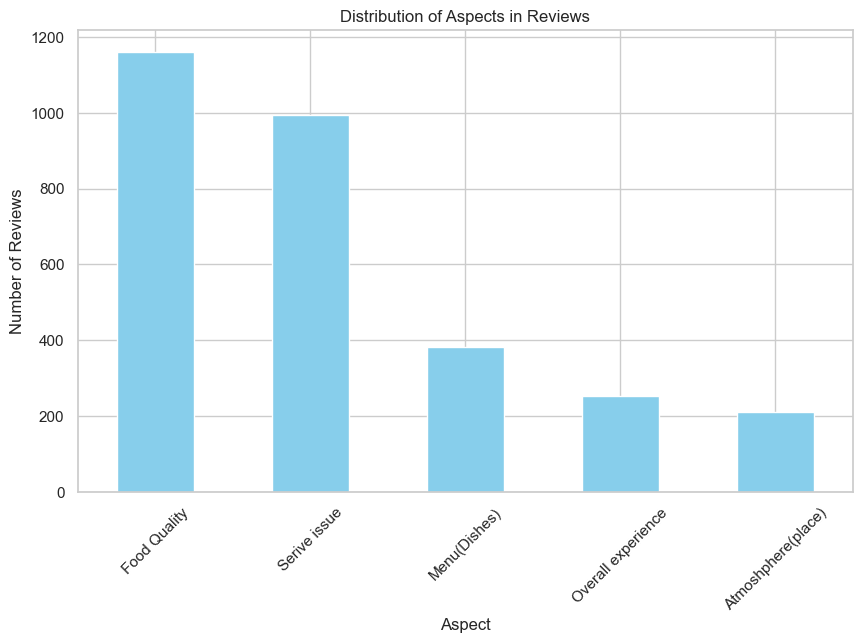

In [45]:
import matplotlib.pyplot as plt

# Count the frequency of each aspect_label
aspect_counts = food_quality_reviews['aspect_label'].value_counts()

# Plot
aspect_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Distribution of Aspects in Reviews')
plt.xlabel('Aspect')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


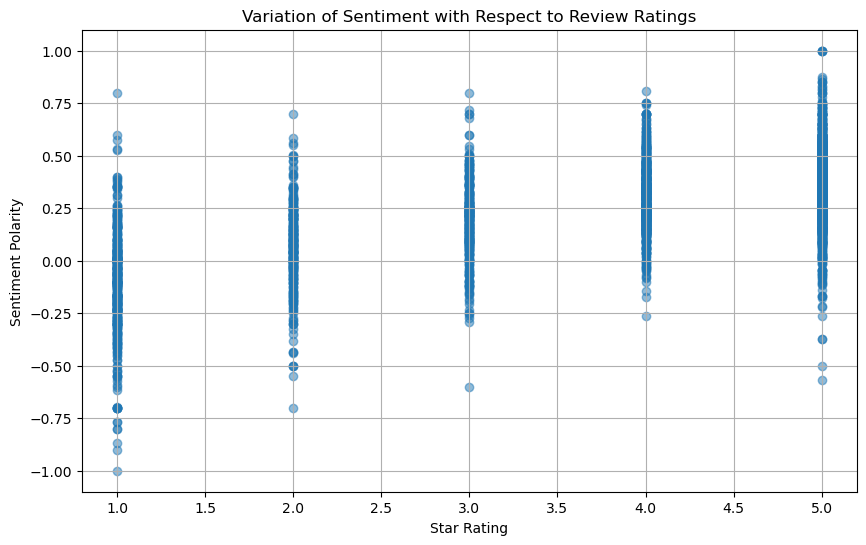

In [36]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_sample['stars'], final_sample['sentiment_polarity'], alpha=0.5)
plt.title('Variation of Sentiment with Respect to Review Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()


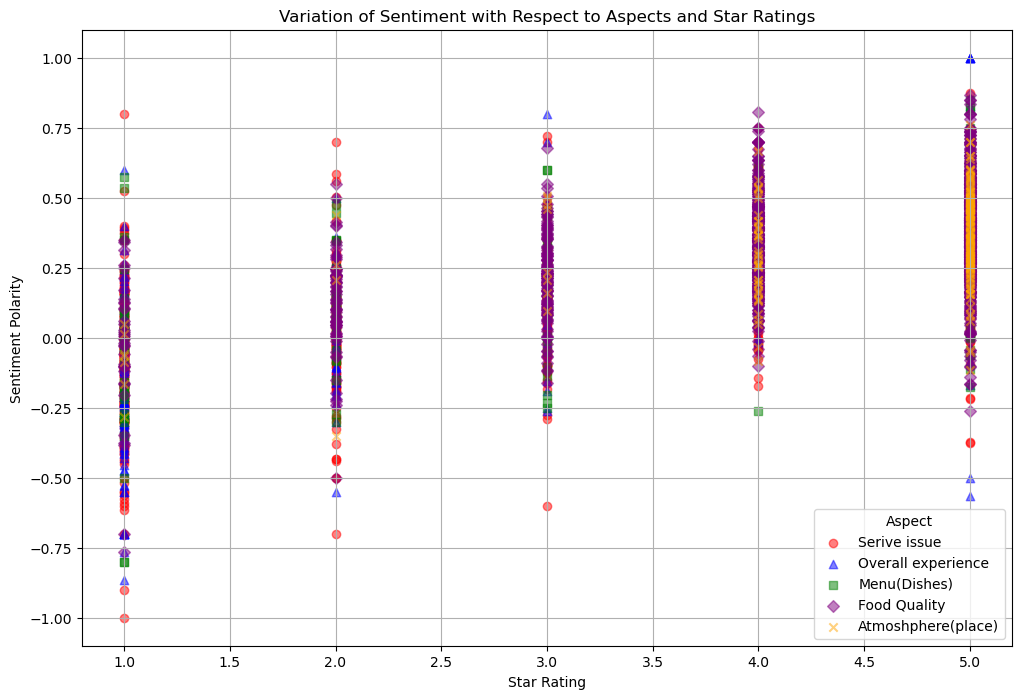

In [37]:
import matplotlib.pyplot as plt

# Unique aspects
aspects = final_sample['aspect_label'].unique()

# Setting up colors/markers (you can customize this)
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['o', '^', 's', 'D', 'x']

# Plotting
plt.figure(figsize=(12, 8))
for aspect, color, marker in zip(aspects, colors, markers):
    subset = final_sample[final_sample['aspect_label'] == aspect]
    plt.scatter(subset['stars'], subset['sentiment_polarity'], alpha=0.5, c=color, marker=marker, label=aspect)

plt.title('Variation of Sentiment with Respect to Aspects and Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Polarity')
plt.legend(title='Aspect')
plt.grid(True)
plt.show()


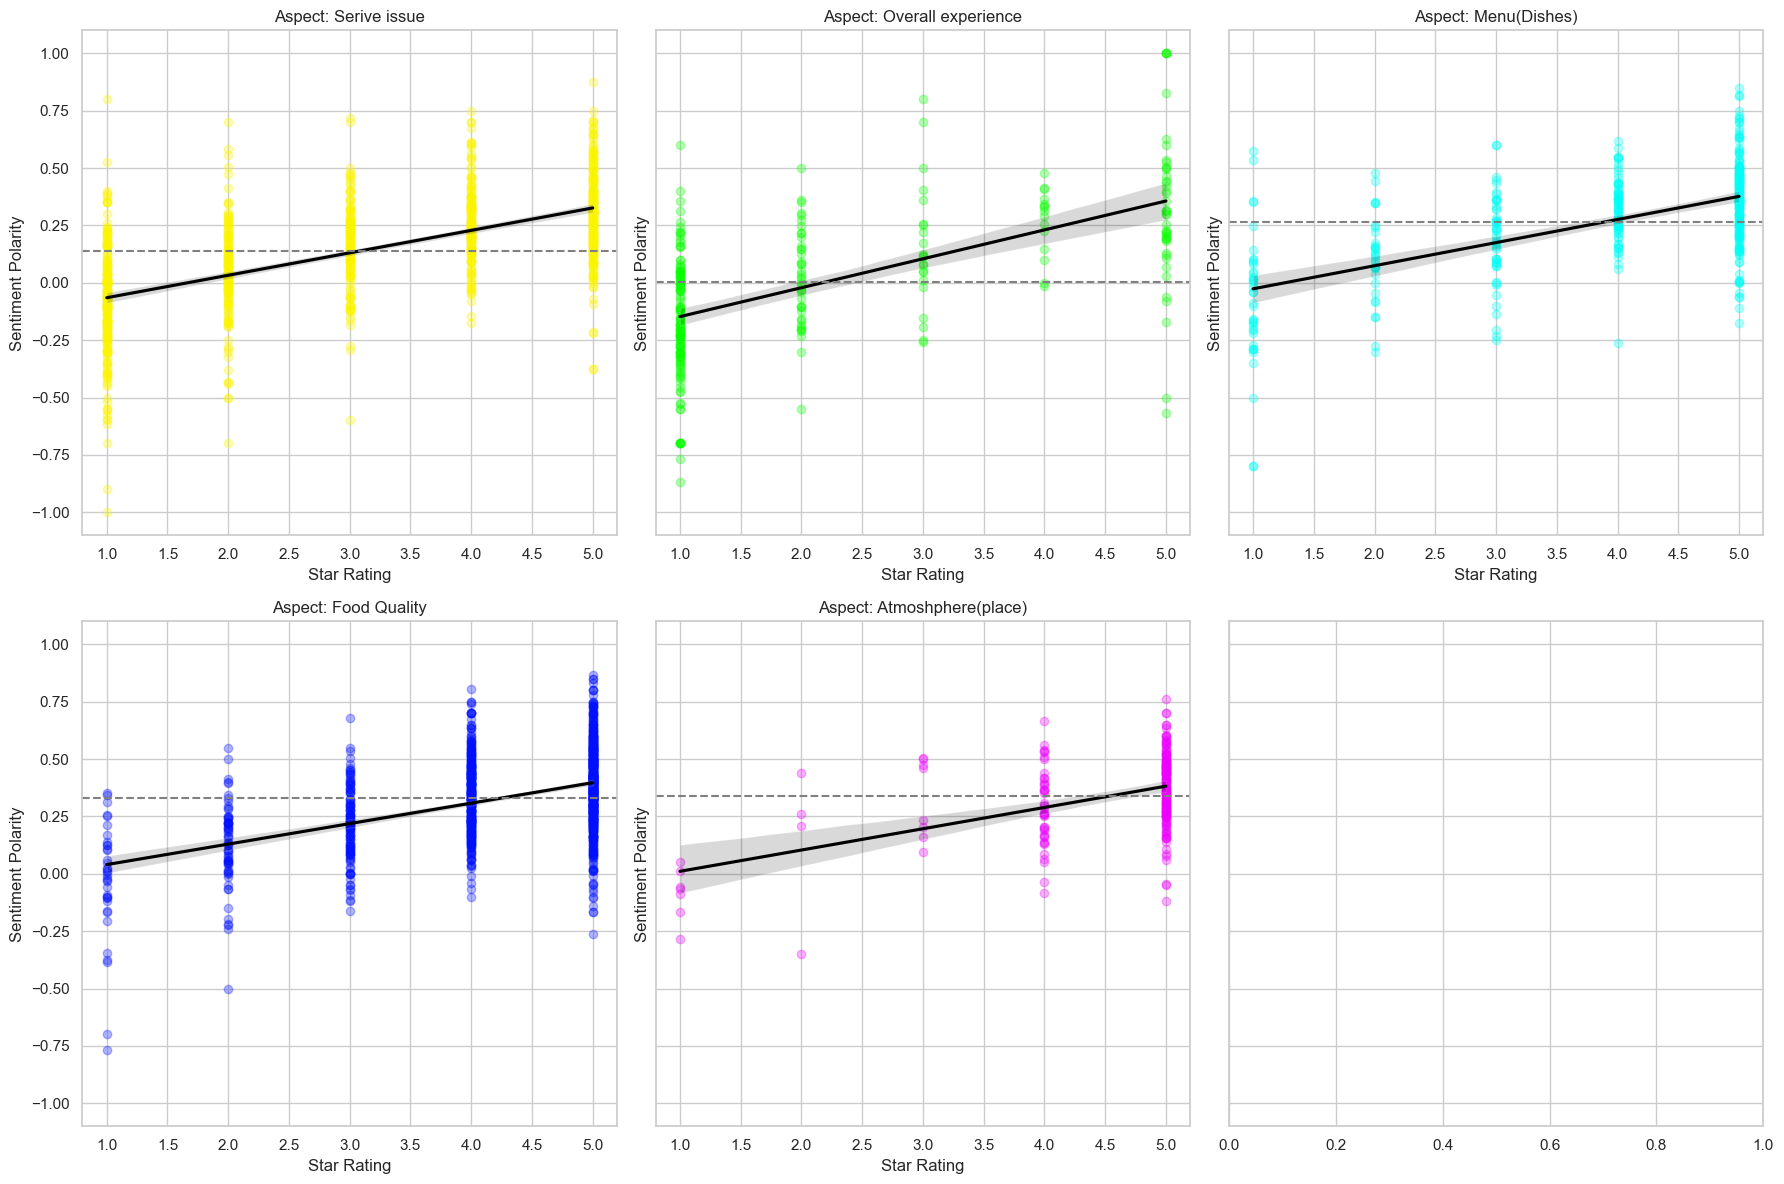

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Setting the style
sns.set(style="whitegrid")

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharey=True)

# Flatten axes array for easy looping
axes = axes.flatten()

# Unique aspects
aspects = final_sample['aspect_label'].unique()

# Colors for each aspect
colors = sns.color_palette("hsv", len(aspects))

# Loop through aspects and create a scatter plot for each
for ax, aspect, color in zip(axes, aspects, colors):
    subset = final_sample[final_sample['aspect_label'] == aspect]
    sns.regplot(x='stars', y='sentiment_polarity', data=subset, ax=ax, color=color, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
    ax.set_title(f'Aspect: {aspect}')
    ax.set_xlabel('Star Rating')
    ax.set_ylabel('Sentiment Polarity')
    # Mean line
    mean_sentiment = subset['sentiment_polarity'].mean()
    ax.axhline(mean_sentiment, color='grey', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()


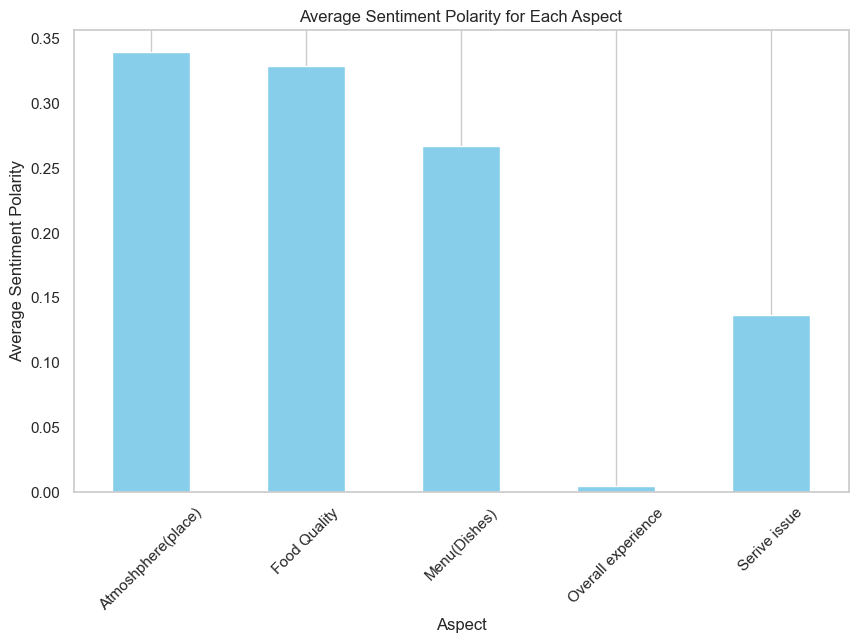

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_sample is your DataFrame
# Calculate the average sentiment for each aspect
average_sentiment_per_aspect = final_sample.groupby('aspect_label')['sentiment_polarity'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_sentiment_per_aspect.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Polarity for Each Aspect')
plt.xlabel('Aspect')
plt.ylabel('Average Sentiment Polarity')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [40]:
import pandas as pd

# Assuming final_sample is your DataFrame
# Count the occurrences of each aspect
aspect_counts = final_sample['aspect_label'].value_counts()

# Display the counts
print(aspect_counts)


aspect_label
Food Quality          1160
Serive issue           994
Menu(Dishes)           381
Overall experience     253
Atmoshphere(place)     212
Name: count, dtype: int64
